### 📌 Partie 1 : Préparation des données

In [225]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


- Lecture du dataset brut

In [226]:
df = pd.read_csv("7_data_regression.csv",encoding="utf-8")

- Gestion des valeurs manquantes

In [227]:
# Variables numériques : médiane
df['superficie'] = df['superficie'].fillna(df['superficie'].median())
df['nombre_chambres'] = df['nombre_chambres'].fillna(df['nombre_chambres'].median())
df['loyer_mensuel'] = df['loyer_mensuel'].fillna(df['loyer_mensuel'].median())

# Variables catégorielles : mode ou valeur par défaut
df['douche_wc'] = df['douche_wc'].fillna(df['douche_wc'].mode()[0])
df['type_d_acces'] = df['type_d_acces'].fillna(df['type_d_acces'].mode()[0])
df['meuble'] = df['meuble'].fillna('non')
df['etat_general'] = df['etat_general'].fillna(df['etat_general'].mode()[0])

- Encodage des variables catégorielles

In [228]:
num_features = ['superficie', 'nombre_chambres']
cat_features = ['quartier', 'douche_wc', 'type_d_acces', 'meuble', 'etat_general']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]
)

## encoder les variables catégorielle avec label encoder
label_encoder = LabelEncoder()
for feature in cat_features:
    df[feature] = label_encoder.fit_transform(df[feature])

print(df.head())


   quartier  superficie  nombre_chambres  douche_wc  type_d_acces  meuble  \
0        14          64                2          1             0       0   
1         9          83                5          0             2       1   
2        10         130                3          1             0       0   
3         0         106                4          1             0       1   
4         8          27                1          1             3       1   

   etat_general  loyer_mensuel  
0             1         489600  
1             0        1096800  
2             2        1190000  
3             1         838400  
4             1         212800  


- Création de variables dérivées

In [229]:
# Prix par m²
df["prix_par_m2"] = df["loyer_mensuel"] / df["superficie"]

# Classification des quartiers
quartiers_residentiels = ["Ivandry", "Ankorondrano", "Ambatobe"]
df["quartier_type"] = df["quartier"].apply(
lambda x: "residentiel" if x in quartiers_residentiels else "populaire"
)

- Détection et suppression des variables fortement corrélées

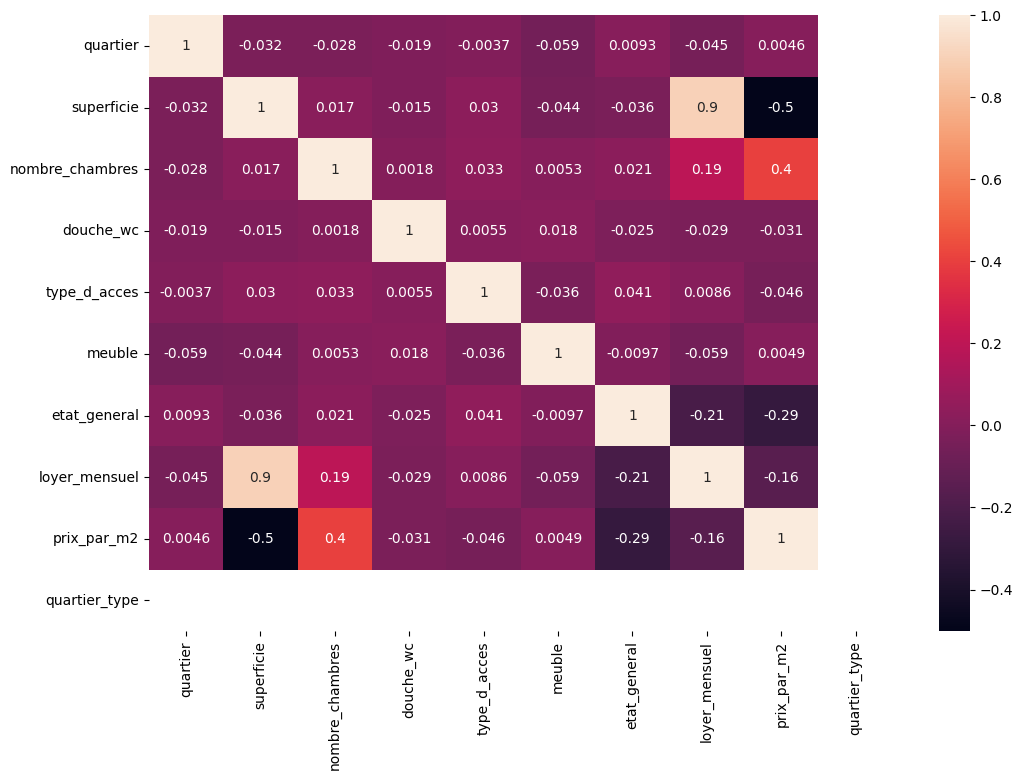

quartier           1.000000
etat_general       0.009250
prix_par_m2        0.004579
type_d_acces      -0.003678
douche_wc         -0.019467
nombre_chambres   -0.028099
superficie        -0.032237
loyer_mensuel     -0.045095
meuble            -0.059465
quartier_type           NaN
Name: quartier, dtype: float64


In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


all_numerique_cols = ['superficie', 'nombre_chambres', 'prix_par_m2']
all_cat_features = ['quartier', 'douche_wc', 'type_d_acces', 'meuble', 'etat_general','quartier_type']

label_encoder = LabelEncoder()
for feature in all_cat_features:
    df[feature] = label_encoder.fit_transform(df[feature])

correlation = df.corr()
## plot pour détecter les varibles fortement correlé
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True)
plt.show()


## suppréssion des variables fortement correlé 
print(correlation['quartier'].sort_values(ascending=False))


- Standardisation et normalisation

In [231]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), all_numerique_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), all_cat_features)
    ])

### 📌 Partie 2 : Modélisation

- Séparation train/test

In [232]:
X = df.drop("loyer_mensuel", axis=1)
y = df["loyer_mensuel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Implémentation de la régression linéaire multiple

In [233]:
# Création du pipeline avec préprocesseur et modèle
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

- Évaluation : R², RMSE

In [234]:

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse  )
print("R² :", r2)

RMSE : 66731.71585508298
R² : 0.9754897765017883


- Vérification des hypothèses d'élligibilité de la régression linéaire multiple (surtout sur les erreurs)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Égalité parfaite")
plt.xlabel("Loyer réel (MGA)")
plt.ylabel("Loyer prédit (MGA)")
plt.title("Comparaison Loyer Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.scatter(y_test, y_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Comparaison Réel vs Prédit")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # diagonale parfaite
plt.show()


In [ ]:
# Comparer RMSE avec la moyenne et l’écart-type des loyers
print("Moyenne des loyers :", y_test.mean())
print("Écart-type des loyers :", y_test.std())
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score :", r2_score(y_test, y_pred))
print(df['loyer_mensuel'].describe())

Moyenne des loyers : 1049338.0
Écart-type des loyers : 427313.9941588856
RMSE : 66731.71585508298
R² Score : 0.9754897765017883
count    1.000000e+03
mean     1.020997e+06
std      4.526890e+05
min      1.872000e+05
25%      6.636000e+05
50%      9.832000e+05
75%      1.333800e+06
max      2.222400e+06
Name: loyer_mensuel, dtype: float64


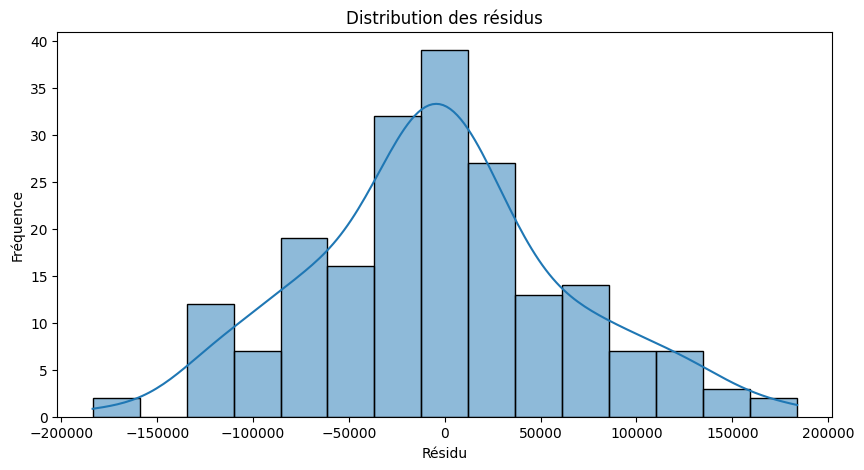

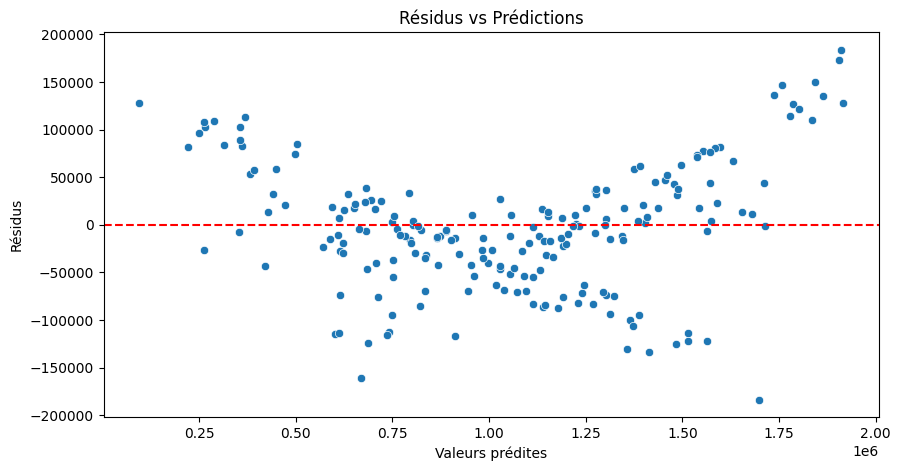

In [237]:
# Affichage des résidus
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Distribution des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.show()

# Résidus vs Prédictions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs Prédictions")
plt.show()

### 📌 Partie 3 : Optimisation du modèle

- Sélection de variables : backward elimination, RFE (à documenter)